In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

# Urban Districts: Distances

<AxesSubplot:>

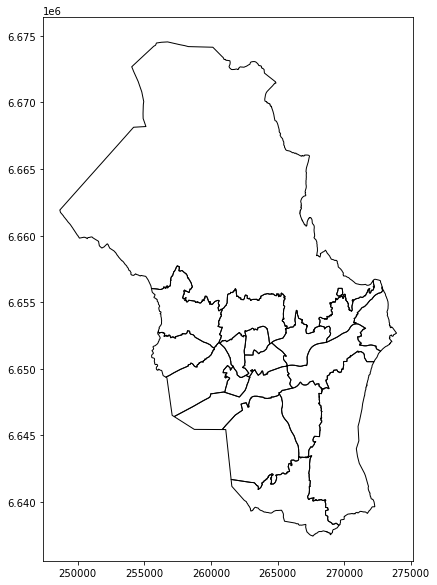

In [2]:
os.chdir('C:\\Users\\SEOP24209\\Desktop\\Om Thesis\\OD_Data\\cloud\\Osloshp\\')
oslo=gpd.read_file('Bydeler.shp')
oslo.plot(figsize = (10,10), facecolor = "None")

In [3]:
oslo.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
#extract the centroids
oslo["Centroids"] = oslo.geometry.centroid
oslo.head()

,bydelsnr,bynavn,geometry,Centroids
0,030101,Oslo,"POLYGON ((257239.610 6646410.660, 257463.220 6...",POINT (261786.768 6647592.750)
1,030102,Oslo,"POLYGON ((262654.140 6649525.620, 262698.000 6...",POINT (264059.131 6650601.945)
2,030103,Oslo,"POLYGON ((263763.030 6651270.210, 263751.220 6...",POINT (263423.702 6652102.490)
3,030104,Oslo,"POLYGON ((262551.850 6650039.510, 262563.650 6...",POINT (261947.805 6651147.768)
4,030105,Oslo,"POLYGON ((256995.380 6647178.720, 256926.290 6...",POINT (259091.425 6649066.155)


In [5]:
oslo.set_index('bydelsnr', inplace=True, drop=True)
#calculate distances from all borough centroids to all borough centroids- lambda function
distances = oslo.rename_axis('OrigCode').Centroids.apply(lambda x: oslo.rename_axis('DestCode').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["OrigCode", "DestCode"], inplace = True)
oslo.reset_index(inplace=True)
pd.DataFrame(distances).reset_index(inplace=True)
distances.drop(columns = ["index"], inplace=True)
distances

,OrigCode,DestCode,Dist
0,030101,030101,0.000000
1,030101,030102,3770.794698
2,030101,030103,4797.635234
3,030101,030104,3558.663472
4,030101,030105,3071.774073
...,...,...,...
284,030117,030113,15276.356293
285,030117,030114,16439.230351
286,030117,030115,20976.358395
287,030117,030116,11816.019111


In [6]:
data = distances
data['OrigCode'] = data['OrigCode'].astype(float)
data['DestCode'] = data['DestCode'].astype(float)
data.head()

,OrigCode,DestCode,Dist
0,30101.0,30101.0,0.000000
1,30101.0,30102.0,3770.794698
2,30101.0,30103.0,4797.635234
3,30101.0,30104.0,3558.663472
4,30101.0,30105.0,3071.774073


# Trip data..

In [27]:
#Acquire data relating districts to grunnkrets
os.chdir('C:\\Users\\SEOP24209\\Desktop\\Om Thesis\\OD_Data\\SSB\\Use\\')
disgru = pd.read_excel('OsloDistGrunn.xlsx')
disgru.rename(columns={"sourceCode":"DistCode", "sourceName":"District", "targetCode":"GrunnCode", "targetName":"Grunnkret"}, inplace = True)
disgru.head()

,DistCode,District,GrunnCode,Grunnkret
0,30101,Gamle Oslo,3012401,Tøyen Rode 1
1,30101,Gamle Oslo,3012408,Tøyen Rode 8
2,30101,Gamle Oslo,3012409,Tøyen Rode 9
3,30101,Gamle Oslo,3012502,Grønland Rode 2
4,30101,Gamle Oslo,3012503,Grønland Rode 3


In [28]:
#add the population- merge on the origins
df = df.merge(disgru, left_on = "OrigCode", right_on ="GrunnCode")
#do the same with the destination
df = df.merge(disgru, left_on = "DestCode", right_on ="GrunnCode")
df.drop(columns={'Grunnkret_y', 'OrigCode', 'DestCode', 'GrunnCode_x', 'Grunnkret_x', 'GrunnCode_y'}, inplace=True)
df.head()

,trips,DistCode_x,District_x,DistCode_y,District_y
0,416,30116,Sentrum,30116,Sentrum
1,278,30116,Sentrum,30116,Sentrum
2,129,30116,Sentrum,30116,Sentrum
3,115,30116,Sentrum,30116,Sentrum
4,58,30116,Sentrum,30116,Sentrum


In [29]:
dff = df.groupby(['DistCode_x', 'DistCode_y', 'District_x', 'District_y'])
df1= dff['trips'].sum()
df = pd.DataFrame(df1)
df1 = df.stack().to_frame().reset_index()
df1.drop(columns={'level_4'}, inplace = True)
df1.rename(columns = {'DistCode_x':'OrigCode', 'DistCode_y':'DestCode', 0:'Trips'}, inplace=True)
df1['OrigCode'] = df1['OrigCode'].astype(float)
df1['DestCode'] = df1['DestCode'].astype(float)
df1.head()

,OrigCode,DestCode,District_x,District_y,Trips
0,30101.0,30101.0,Gamle Oslo,Gamle Oslo,54156
1,30101.0,30102.0,Gamle Oslo,Grünerløkka,18469
2,30101.0,30103.0,Gamle Oslo,Sagene,9668
3,30101.0,30104.0,Gamle Oslo,St. Hanshaugen,12592
4,30101.0,30105.0,Gamle Oslo,Frogner,14549


# Compiling all data

In [30]:
#Final employment data for compiling
empl.head()

,region,district,Employed19
0,030101,Bygdøy-Frogner (1988-2003),0.0
1,030101a,Gamle Oslo,43121.0
2,030102,Uranienborg -Majorstuen (1988-2003),0.0
3,030102a,Grünerløkka,29560.0
4,030103,St.Hanshaugen-Ullevål (1988-2003),0.0


## Trips and Distances

In [31]:
#add the trips- merge on the origins- columns to distances dataframe
df = df1.merge(data['Dist'], left_index=True, right_index=True)
df.head()

,OrigCode,DestCode,District_x,District_y,Trips,Dist
0,30101.0,30101.0,Gamle Oslo,Gamle Oslo,54156,0.000000
1,30101.0,30102.0,Gamle Oslo,Grünerløkka,18469,3770.794698
2,30101.0,30103.0,Gamle Oslo,Sagene,9668,4797.635234
3,30101.0,30104.0,Gamle Oslo,St. Hanshaugen,12592,3558.663472
4,30101.0,30105.0,Gamle Oslo,Frogner,14549,3071.774073


## Population at Origin

In [32]:
#Load commuting data
os.chdir('C:\\Users\\SEOP24209\\Desktop\\Om Thesis\\OD_Data\\cloud\\')
# Read Origin-Destination table from the csv , dtype={"people": "float64"}
pop = pd.read_excel('10826OPopUD.xlsx')
pop.drop(columns={'district'}, inplace=True)
pop.head()

,code,Pop19
0,30101,39735
1,30102,43934
2,30103,31630
3,30104,27074
4,30105,39784


In [33]:
#add the population- merge on the origins
data = df.merge(pop, left_on = "OrigCode", right_on ="code")
#do the same with the destination
data = data.merge(pop, left_on = "DestCode", right_on ="code")
data.drop(columns={'code_x', 'code_y'}, inplace=True)
data.head()

,OrigCode,DestCode,District_x,District_y,Trips,Dist,Pop19_x,Pop19_y
0,30101.0,30101.0,Gamle Oslo,Gamle Oslo,54156,0.000000,39735,39735
1,30102.0,30101.0,Grünerløkka,Gamle Oslo,18715,3770.794698,43934,39735
2,30103.0,30101.0,Sagene,Gamle Oslo,9690,4797.635234,31630,39735
3,30104.0,30101.0,St. Hanshaugen,Gamle Oslo,12727,3558.663472,27074,39735
4,30105.0,30101.0,Frogner,Gamle Oslo,14509,3071.774073,39784,39735


## Employment at Destination

In [34]:
#add the employment- merge on the destination
data = data.merge(empl, left_on = "District_y", right_on ="district")
data.drop(columns={'Pop19_y', 'region', 'district'}, inplace=True)
datasub = data[data["Dist"] != 0]
datasub.head()

,OrigCode,DestCode,District_x,District_y,Trips,Dist,Pop19_x,Employed19
1,30102.0,30101.0,Grünerløkka,Gamle Oslo,18715,3770.794698,43934,43121.0
2,30103.0,30101.0,Sagene,Gamle Oslo,9690,4797.635234,31630,43121.0
3,30104.0,30101.0,St. Hanshaugen,Gamle Oslo,12727,3558.663472,27074,43121.0
4,30105.0,30101.0,Frogner,Gamle Oslo,14509,3071.774073,39784,43121.0
5,30106.0,30101.0,Ullern,Gamle Oslo,5644,5495.850695,19466,43121.0


# Visualizing Traffic Flows

In [35]:
oslo.rename(columns={'bydelsnr':'District'}, inplace = True)
oslo.drop(columns={'bynavn'}, inplace = True)
oslo['District'] = oslo['District'].astype(float)
oslo.head()

,District,geometry,Centroids
0,30101.0,"POLYGON ((257239.610 6646410.660, 257463.220 6...",POINT (261786.768 6647592.750)
1,30102.0,"POLYGON ((262654.140 6649525.620, 262698.000 6...",POINT (264059.131 6650601.945)
2,30103.0,"POLYGON ((263763.030 6651270.210, 263751.220 6...",POINT (263423.702 6652102.490)
3,30104.0,"POLYGON ((262551.850 6650039.510, 262563.650 6...",POINT (261947.805 6651147.768)
4,30105.0,"POLYGON ((256995.380 6647178.720, 256926.290 6...",POINT (259091.425 6649066.155)


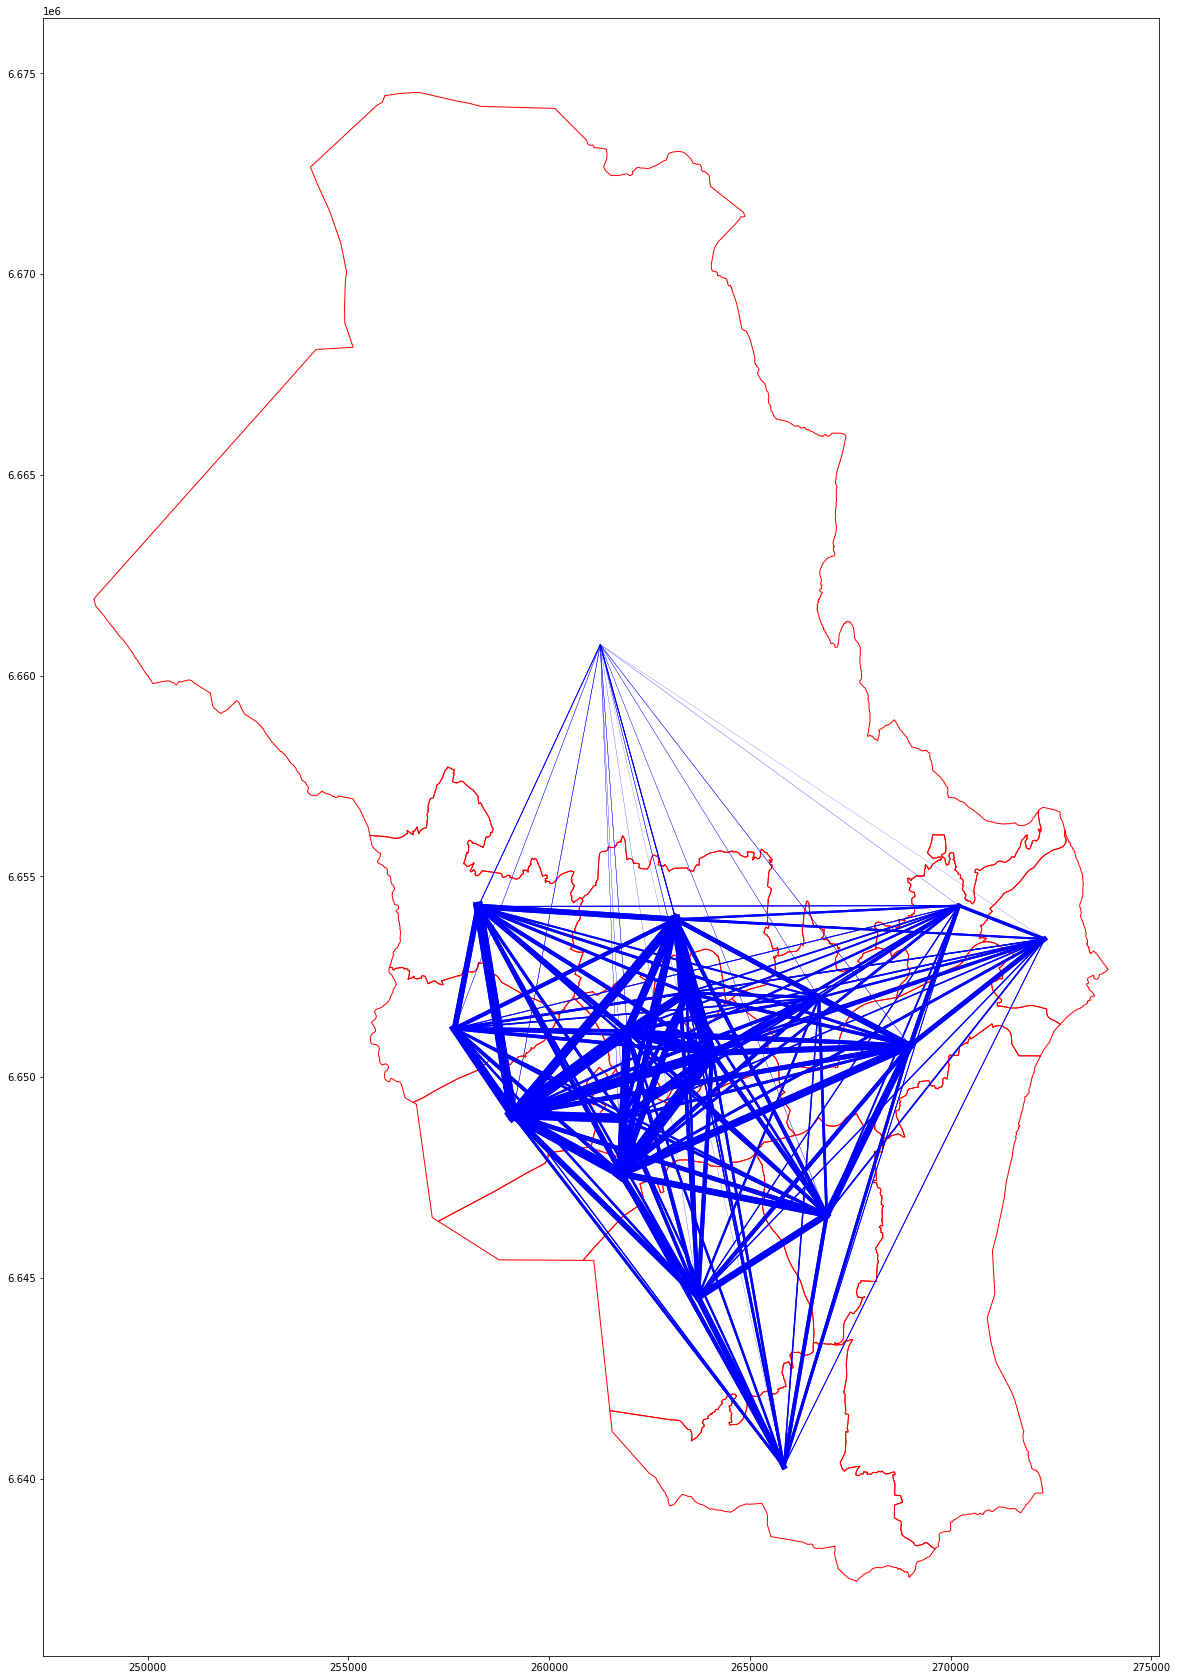

In [36]:
#plot the base map
oslo.plot(figsize = (20,40), facecolor = "None", edgecolor = "r")

#iterate over each pair
for index, row in datasub.iterrows():
    #get the x coordinates
    x1 = [oslo[oslo["District"] == row["OrigCode"]]["Centroids"].x, oslo[oslo["District"] == row["DestCode"]]["Centroids"].x]
    #get the y coordinates
    y1 = [oslo[oslo["District"] == row["OrigCode"]]["Centroids"].y, oslo[oslo["District"] == row["DestCode"]]["Centroids"].y]
#print(f'x1: {x1}, y1: {y1}')
    #plot the line between the x and y coordinates with width reflecting the number of flows
    plt.plot(x1, y1, linewidth = row["Trips"]/max(datasub["Trips"])*12, color = "Blue")

In [37]:
import folium
#set the base map to locate on Oslo
my_map = folium.Map(location = [59.9, 10.75], zoom_start = 11)
oslo_1 = oslo.to_crs("EPSG:4326")
oslo_1["x"] = oslo_1.geometry.centroid.map(lambda p: p.y)
oslo_1["y"]= oslo_1.geometry.centroid.map(lambda p: p.x)

#plot in leaflet using the folium library
#iterate over each pair
for index, row in datasub.iterrows():
    #get the first set of coordinates
    a1 = [oslo_1[oslo_1["District"]==row["OrigCode"]]["x"].values[0],
          oslo_1[oslo_1["District"]==row["OrigCode"]]["y"].values[0]]
    #get the second set of coordinates
    a2 = [oslo_1[oslo_1["District"]==row["DestCode"]]["x"].values[0],
          oslo_1[oslo_1["District"]==row["DestCode"]]["y"].values[0]]
    #create a list of the coordinates
    coords = [a1, a2]
    #add a polyline with size reflective of the number of people
    folium.vector_layers.PolyLine(coords, weight = row["Trips"]/max(datasub["Trips"])*20,opacity = 0.5).add_to(my_map)
#plot the map                                
my_map

In [38]:
#we can create a pivot table to turn paired list into a matrix, and compute the margin as well
UDflows = pd.pivot_table(datasub, values ="Trips", index="OrigCode", columns = "DestCode",aggfunc=np.sum, margins=True)
UDflows

DestCode,30101.0,30102.0,30103.0,30104.0,30105.0,30106.0,30107.0,30108.0,30109.0,30110.0,30111.0,30112.0,30113.0,30114.0,30115.0,30116.0,30117.0,All
OrigCode,,,,,,,,,,,,,,,,,,
30101.0,NaN,18469.0,9668.0,12592.0,14549.0,5653.0,6155.0,9544.0,6256.0,4021.0,4182.0,11523.0,9885.0,9447.0,5692.0,11361.0,380.0,139377
30102.0,18715.0,NaN,15488.0,15743.0,14880.0,5328.0,6017.0,11666.0,7503.0,3918.0,3956.0,8985.0,6438.0,6551.0,3847.0,9811.0,565.0,139411
30103.0,9690.0,15379.0,NaN,11580.0,10563.0,4047.0,4572.0,13830.0,4755.0,2484.0,1978.0,5384.0,3673.0,3724.0,1800.0,5477.0,611.0,99547
30104.0,12727.0,15837.0,11780.0,NaN,18561.0,5378.0,7374.0,11459.0,4259.0,2641.0,2443.0,5946.0,5519.0,5896.0,3562.0,12214.0,567.0,126163
30105.0,14509.0,14859.0,10579.0,18712.0,NaN,12645.0,14795.0,13840.0,5101.0,3352.0,3225.0,7528.0,6848.0,8486.0,4208.0,14508.0,711.0,153906
30106.0,5644.0,5510.0,3964.0,5706.0,12633.0,NaN,8621.0,6185.0,2397.0,1431.0,1367.0,3386.0,3048.0,3539.0,1803.0,3998.0,508.0,69740
30107.0,6307.0,6253.0,4656.0,7633.0,14686.0,8634.0,NaN,8673.0,2941.0,1491.0,1421.0,4254.0,3315.0,3662.0,2016.0,4681.0,1284.0,81907
30108.0,9597.0,11759.0,13792.0,11762.0,14255.0,6102.0,8739.0,NaN,5834.0,3396.0,3027.0,6748.0,5661.0,5566.0,3025.0,6294.0,1417.0,116974
30109.0,6242.0,7476.0,4685.0,4267.0,5197.0,2412.0,2829.0,5961.0,NaN,3746.0,3510.0,9080.0,4120.0,3211.0,2064.0,2896.0,441.0,68137
